# 06_NLP Cleaning, EDA & Modeling (2 Classes)

# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, balanced_accuracy_score
from functools import partial
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_colwidth = 400

# 2. Load Data

In [354]:
# Importing dataframe
df = pd.read_csv('../data/protests_original.csv')

# 3. Data Cleaning

In [355]:
# Filling the state response columns with na to make them easier to work with
columns_list = ['stateresponse1','stateresponse2','stateresponse3','stateresponse4','stateresponse5','stateresponse6','stateresponse7']

for col in columns_list:
    df[col] = df[col].fillna('na')

In [356]:
# Combining all the 7 state responses into one
df['allresponses'] = df['stateresponse1'] + ', ' + \
                      df['stateresponse2'] + ', ' + \
                      df['stateresponse3'] + ', ' + \
                      df['stateresponse4'] + ', ' + \
                      df['stateresponse5'] + ', ' + \
                      df['stateresponse6'] + ', ' + \
                      df['stateresponse7'] + ', '

In [357]:
# Organizing the state responses to keep the most severe state response in each row
mostsevereresponse = []

for i in df['allresponses']:
    if 'killings' in i:
        mostsevereresponse.append('killings')
    elif 'shootings' in i:
        mostsevereresponse.append('shootings')
    elif 'beatings' in i:
        mostsevereresponse.append('beatings')
    elif 'arrests' in i:
        mostsevereresponse.append('arrests')
    elif 'crowd dispersal' in i:
        mostsevereresponse.append('crowd dispersal')
    elif 'accomodation' in i:
        mostsevereresponse.append('accomodation')
    elif 'ignore' in i:
        mostsevereresponse.append('ignore')
    else:
        mostsevereresponse.append(np.nan)

In [358]:
# Merging all the state responses back into one column and dropping the others
df['stateresponse'] = mostsevereresponse

df.drop(columns=['stateresponse1','stateresponse2','stateresponse3','stateresponse4','stateresponse5','stateresponse6','stateresponse7','allresponses'], inplace=True)

In [359]:
# Dropping any null state responses that were left
df.dropna(subset=['stateresponse'], how='all', inplace=True)

In [360]:
# Renaming columns to make them more readable and easier to work with
df.rename(columns = {'protesterviolence': 'protester_violence', 
                      'protesteridentity': 'protester_identity',
                      'protesterdemand1': 'protester_demand', 
                      'stateresponse': 'state_response'}, inplace=True)

In [361]:
# Categorizing each state response by negative if the state's response to the protest led to protesters being arrested,
# beaten, shot, or killed. All other responses were inputed as non-negative.
def categorise(row):  
    if row['state_response'] == 'ignore':
        return 'non-negative'
    elif row['state_response'] == 'crowd dispersal':
        return 'non-negative'
    elif row['state_response'] == 'accomodation':
        return 'non-negative'
    elif row['state_response'] == 'arrests':
        return 'negative'
    elif row['state_response'] == 'killings':
        return 'negative'
    elif row['state_response'] == 'shootings':
        return 'negative'
    elif row['state_response'] == 'beatings':
        return 'negative'
    
df['state_response_2'] = df.apply(lambda row: categorise(row), axis=1)

In [362]:
# Only keeping the features that i will be using for NLP
protest_nlp = df.loc[:, ('notes', 'state_response', 'state_response_2')]

In [363]:
# Checking for null values in notes
protest_nlp['notes'].isnull().sum()

46

In [364]:
# dropping the 46 null rows in notes
protest_nlp.dropna(subset=['notes'], inplace=True)

In [365]:
# We can see that the our data is greatly unbalanced so we will eventually need to balance before we model our data.
protest_nlp['state_response_2'].value_counts()

non-negative    11704
negative         3460
Name: state_response_2, dtype: int64

In [366]:
# Removing these breaks from text
protest_nlp['notes'] = protest_nlp['notes'].map(lambda x: x.replace('\n', ' '))

# Removing these words from text (result of ampersand)
protest_nlp['notes'] = protest_nlp['notes'].map(lambda x: x.replace('amp', ''))

In [367]:
# Lowering words in notes column
protest_nlp['notes'] = protest_nlp['notes'].str.lower()

In [368]:
# Tokenizing for lemmatizing and stemming
tokenizer = RegexpTokenizer(r'[a-z]\w+')

protest_nlp['notes'] = protest_nlp['notes'].transform(tokenizer.tokenize)

In [369]:
# Lemmatizing and stemming 
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for token_list in protest_nlp['notes']:
    [p_stemmer.stem(i) for i in token_list]
    [lemmatizer.lemmatize(i) for i in token_list]
    
protest_nlp['notes'] = protest_nlp['notes'].map(lambda x: ' '.join(x))

In [370]:
# Removing punctuation and lower casing all letters.
protest_nlp['notes'] = protest_nlp['notes'].str.replace(r'[^\w\s]+', '').str.lower()

# 4. Exploratory Data Analysis

### 4.1 Creating Related Features

In [371]:
# Making word count and character count for notes, we want to see if there is big differences between the two state responses.
protest_nlp['word_count'] = protest_nlp['notes'].map(len)
protest_nlp['character_count'] = protest_nlp['notes'].map(lambda x: len(x.split(' ')))

In [372]:
protest_nlp.describe()

,word_count,character_count
count,15164.000000,15164.000000
mean,579.311329,92.786006
std,573.665639,92.600046
min,3.000000,1.000000
25%,204.000000,33.000000
50%,438.000000,69.000000
75%,766.000000,122.000000
max,13792.000000,2231.000000


### 4.2 Feature Exploration

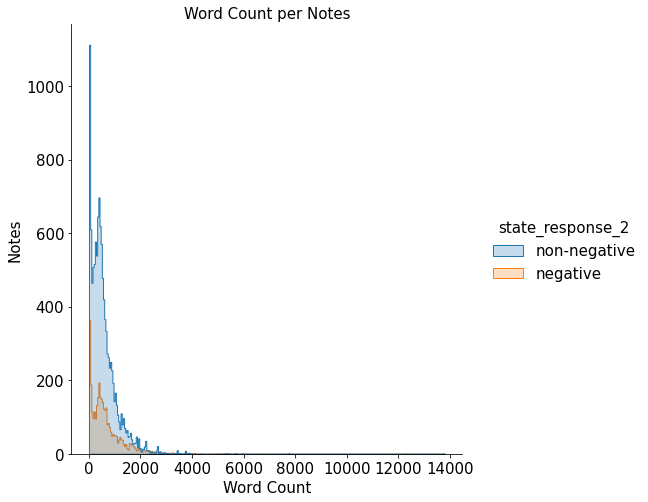

In [491]:
# plotting word count seperated by Negative and Positive state responses
sns.displot(protest_nlp, x="word_count", hue="state_response_2", element='step', height=7)
plt.title('Word Count per Notes',fontsize=15)
plt.xlabel('Word Count', fontsize=15)
plt.ylabel('Notes', fontsize=15);

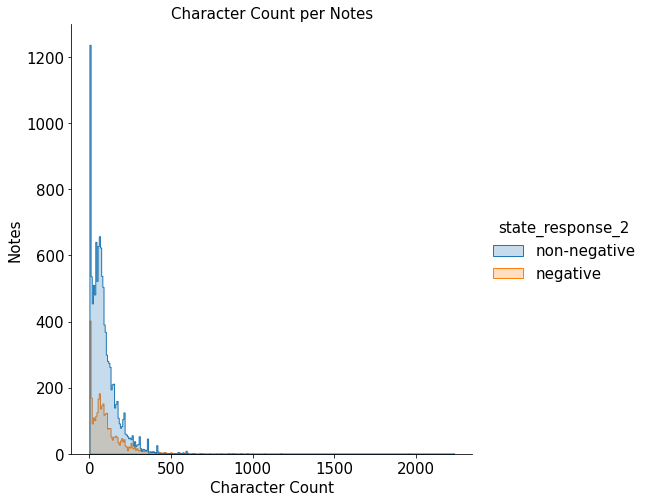

In [492]:
# plotting character count seperated by Negative and Positive state responses
sns.displot(protest_nlp, x="character_count", hue="state_response_2", element='step', height=7)
plt.title('Character Count per Notes',fontsize=15)
plt.xlabel('Character Count', fontsize=15)
plt.ylabel('Notes', fontsize=15);

In [375]:
# Total words and characters in Notes
print('Total words in Notes: ' + str(protest_nlp['word_count'].sum()))
print('Total characters in Notes: ' + str(protest_nlp['character_count'].sum()))

Total words in Notes: 8784677
Total characters in Notes: 1407007


The top two graphs visually show us how unbalanced the data is, there are more non-negative state responses. What we like to point out on these graphs are that even with more notes for the non-negative state responses it seems like the follow a similar skewed graph pattern for the character count and word count. 

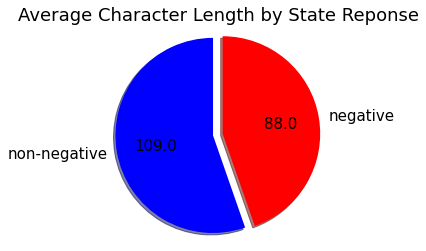

In [499]:
def absolute_value(val):
    """Returns absolute values for display on a plt pie chart."""
    return np.round(val / 100 * sizes.sum(), 0)

labels = ['non-negative', 'negative']
sizes = protest_nlp.groupby(by='state_response_2').mean()['character_count']
explode = (0, 0.1)

plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
ax1.set_title('Average Character Length by State Reponse')
ax1.pie(sizes, explode=explode, labels=labels, colors=['blue', 'red'], autopct=absolute_value,
        shadow=True, startangle=90, )
ax1.axis('equal') 

plt.show()

### 4.3 WordCloud

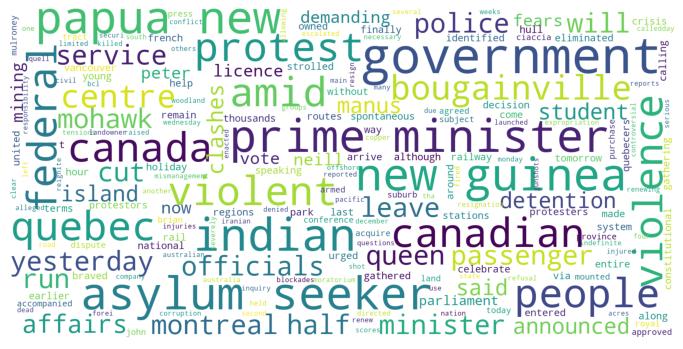

In [377]:
stopwords = set(STOPWORDS)
data = protest_nlp['notes']
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=30,
        scale=4,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data)

Many of the words that populated on the word cloud are places or individuals that were part of the protest. Canada is a top word and the country only had 53 entries but when we looked further into it we noticed that in most Canadian notes they tend to use the word Canada or canadian multiple times per note. The country with the most notes was the United Kingdom and we can see the influence with some of the top words that populated.

### 4.4 Count Vectorizer

In [378]:
cvex = CountVectorizer(stop_words='english')
c_data = cvex.fit_transform(protest_nlp['notes'])
c_data = pd.DataFrame(c_data.todense(), columns=cvex.get_feature_names_out())

In [379]:
c_data.shape

(15164, 37940)

In [380]:
# Top 10 most common words in notes
c_data.sum().sort_values(ascending=False).head(10)

police        11390
protest        8673
government     8519
said           7603
people         7162
protesters     7071
protests       5194
president      3985
capital        3479
thousands      3381
dtype: int64

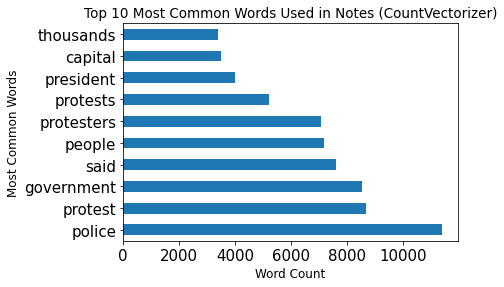

In [381]:
# Plotting top 10 most common words from countvectorizer
c_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Notes (CountVectorizer)', fontsize=13.5);

In [382]:
# Making a new df for negative state responses 
protest_negative = protest_nlp[protest_nlp['state_response_2'].isin(['negative'])]

In [383]:
cvex = CountVectorizer(stop_words='english')
c_neg_data = cvex.fit_transform(protest_negative['notes'])
c_neg_data = pd.DataFrame(c_neg_data.todense(), columns=cvex.get_feature_names_out())

c_neg_data.shape

(3460, 17952)

In [384]:
# Top 10 most common words in notes with negative state responses.
c_neg_data.sum().sort_values(ascending=False).head(10)

police           5625
said             2721
protesters       2594
people           2517
government       1949
protest          1948
protests         1692
demonstrators    1218
arrested         1197
capital          1055
dtype: int64

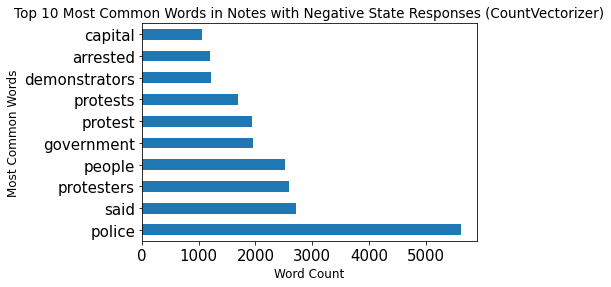

In [385]:
# Plotting top 10 most common words with negative state responses
c_neg_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words in Notes with Negative State Responses (CountVectorizer)', fontsize=13.5);

In [386]:
# Making a new df for positive state responses 
protest_nonneg = protest_nlp[protest_nlp['state_response_2'].isin(['non-negative'])]

In [387]:
cvex = CountVectorizer(stop_words='english')
c_nonneg_data = cvex.fit_transform(protest_nonneg['notes'])
c_nonneg_data = pd.DataFrame(c_nonneg_data.todense(), columns=cvex.get_feature_names_out())

c_nonneg_data.shape

(11704, 33212)

In [388]:
# Top 10 most common words in notes with negative state responses.
c_nonneg_data.sum().sort_values(ascending=False).head(10)

protest       6725
government    6570
police        5765
said          4882
people        4645
protesters    4477
protests      3502
president     3016
thousands     2722
country       2546
dtype: int64

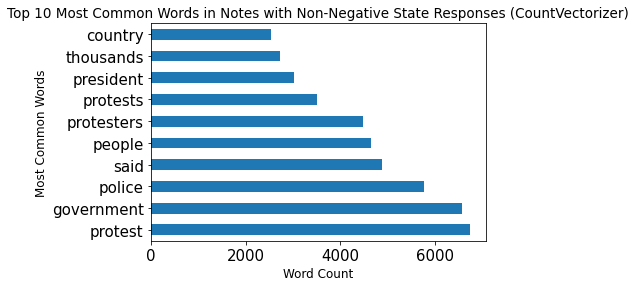

In [389]:
# Plotting top 10 most common words with negative state responses
c_nonneg_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words in Notes with Non-Negative State Responses (CountVectorizer)', fontsize=13.5);

CountVectorizer for both state responses was able to identify 37936 words. We decided to run a model for both responses together, negative response, and non-negative response. We see 'police' with 11386 words and in the lead by over 300 words. The top 10 most common words with 'negative' state responses, we did see police with an overwhelming amount. This is because all of the negative state interactions are cause by police. The top 10 most common words with 'positive' state interactions removed the word 'police' from the top most common words and replaced it with 'protest'.

### 4.5 TfidfVectorizer

In [390]:
#TfidfVecotizer
tvec = TfidfVectorizer(stop_words='english')

tvec_data = tvec.fit_transform(protest_nlp['notes'])
tvec_data = pd.DataFrame(tvec_data.todense(), columns=tvec.get_feature_names_out())
tvec_data.shape

(15164, 37940)

In [391]:
# Top 10 most common words in notes using tfidfVectorizer
tvec_data.sum().sort_values(ascending=False).head(10)

police        470.446501
protest       382.832906
government    367.559449
strike        326.483353
people        321.398904
protesters    312.410874
said          293.892746
protests      283.234269
students      222.469027
general       217.252056
dtype: float64

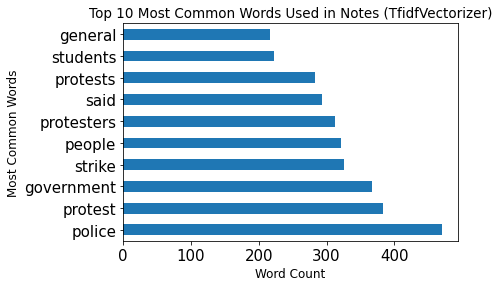

In [392]:
# Plotting top 10 most common words in notes using tfidfVectorizer
tvec_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Notes (TfidfVectorizer)', fontsize=13.5);

In [393]:
# TfidfVecotrizer for negative state responses
tvec = TfidfVectorizer(max_df = 800, stop_words='english')

tvec_neg_data = tvec.fit_transform(protest_negative['notes'])
tvec_neg_data = pd.DataFrame(tvec_neg_data.todense(), columns=tvec.get_feature_names_out())
tvec_neg_data.shape

(3460, 17943)

In [394]:
# Top 10 most common words in notes using tfidfVectorizer
tvec_neg_data.sum().sort_values(ascending=False).head(10)

students      75.347877
opposition    61.667877
riot          53.687943
gas           53.059490
capital       52.684501
number        52.557464
president     51.322489
tear          50.739879
security      48.753745
killed        47.196110
dtype: float64

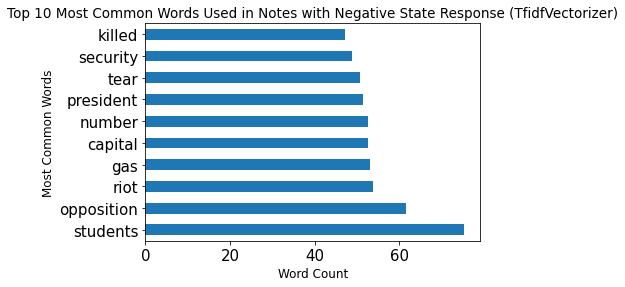

In [395]:
# Plotting top 10 most common words in notes using tfidfVectorizer
tvec_neg_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Notes with Negative State Response (TfidfVectorizer)', fontsize=13.5);

In [396]:
# Tfidf for non-negative state responses
tvec = TfidfVectorizer(max_df=800, stop_words='english')

tvec_nonneg_data = tvec.fit_transform(protest_nonneg['notes'])
tvec_nonneg_data = pd.DataFrame(tvec_nonneg_data.todense(), columns=tvec.get_feature_names_out())
tvec_nonneg_data.shape

(11704, 33150)

In [397]:
# Top 10 most common words in notes using tfidfVectorizer
tvec_nonneg_data.sum().sort_values(ascending=False).head(10)

general       239.712195
women          82.968113
election       79.703273
tear           79.405548
teachers       79.175270
thursday       78.039805
university     76.742928
staged         75.266824
number         75.089722
farmers        74.032185
dtype: float64

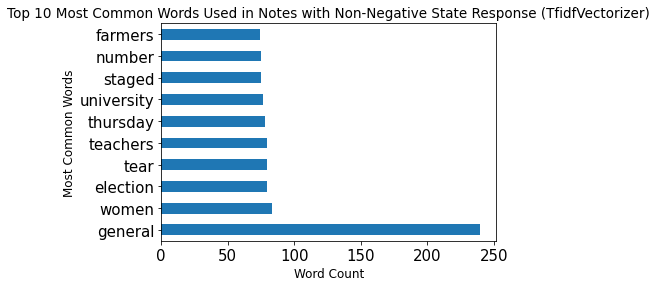

In [398]:
# Plotting top 10 most common words in notes using tfidfVectorizer
tvec_nonneg_data.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Most Common Words', fontsize=12)
plt.title('Top 10 Most Common Words Used in Notes with Non-Negative State Response (TfidfVectorizer)', fontsize=13.5);

In [399]:
protest_nlp['state_response_2'].value_counts(normalize=True)

non-negative    0.771828
negative        0.228172
Name: state_response_2, dtype: float64

TfidfVectorizer identified 38783 words. We decided to run the model for both responses together, negative response, and non-negative response. The top 10 words for both classes mostly identifies the group of people who were protesting (students, teachers, women). For the top 10 most common words for the negative class the major diffrence was that it seemed to identify words that were more like actions that happened at the protest (riot, gas, killed). For the most common words in the non-negative class it had the same top words as both classes together, except for 'general' was in the most common spot and in the both class most common words it did not even make top 10.

# 5. Modeling Untrained Data

In [400]:
# Adding numeric values to state responses for modeling 
state_response_3 = []

nonnegative = ['non-negative']

for i in protest_nlp['state_response_2']:
    if i in nonnegative:
        state_response_3.append(0)
    else:
        state_response_3.append(1)

print(len(state_response_3))

15164


In [401]:
protest_nlp['state_response_3'] = state_response_3

### 5.1 Train/Test/Split

In [402]:
# using the notes as the X to identify the states response y.
X = protest_nlp['notes']
y = protest_nlp['state_response_3']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=9,
    test_size=0.3,
    stratify=y)

### 5.2 Untrained Data

In [403]:
count_vect = CountVectorizer()

X_train_cvec = count_vect.fit_transform(X_train)

print(X_train_cvec.shape)

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

(10614, 32211)


In [404]:
print("Number of training documents: ", X_train.shape[0])

Number of training documents:  10614


In [405]:
#tfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cvec)
X_train_tfidf.shape

(10614, 32211)

In [406]:
# Even though the data is very unbalanced we are running a simple model to see how it responds 
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.771828
1    0.228172
Name: state_response_3, dtype: float64
0    0.771811
1    0.228189
Name: state_response_3, dtype: float64
0    0.771868
1    0.228132
Name: state_response_3, dtype: float64


In [407]:
# Fitting a LogisticRegression model with our untrained data
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [408]:
X_test_cvec = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_cvec)

predicted = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, predicted))

Accuracy: 0.8389010989010989


In [409]:
print(classification_report(y_test,
                            predicted, 
                            target_names = ['non-negative', 'negative']))

              precision    recall  f1-score   support

non-negative       0.85      0.95      0.90      3512
    negative       0.74      0.45      0.56      1038

    accuracy                           0.84      4550
   macro avg       0.80      0.70      0.73      4550
weighted avg       0.83      0.84      0.82      4550



In [410]:
print("balanced_accuracy", balanced_accuracy_score(y_test, 
                                                   predicted))

balanced_accuracy 0.7008700694782766


Our unbalanced data accuracy score is 83%, much higher than was expected. Unfortunately because the data is very unbalanced that score is not reliable. Even though we are only focusing on accuracy for this project we can see how bad the f1-score and reacall were for the negative response, which was the column with the least amount of notes.

# 6. Balancing Data

### Model Scores DataFrame:

In [452]:
model_scores = pd.DataFrame(columns = ['Train Score', 'Test Score', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                          index = ['LogisticRegression_Oversample', 'XGBClassifier_Oversample', 'MultinomialNB_Oversample', 'XGBClassifier_Undersample'])

In [453]:
# Train/Test/Split
def eval_model(X_train, y_train, X_test, y_test, pipe : Pipeline):

    model = pipe.fit(X_train, 
                     y_train)

    pred  = model.predict(X_test)

    print(classification_report(y_test,
                                pred, 
                                target_names=['positive', 'negative']))
    
    print()

In [454]:
#https://docs.python.org/2/library/functools.html

# Using partial so we only have to feed in the different pipelines every time
eval_pipeline = partial(evaluate_model, X_train, y_train, X_test, y_test)

### 6.1 LogisticRegression & Over Sampling

In [455]:
logreg_pipe  = Pipeline([('cvect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('logreg', LogisticRegression())])

In [456]:
cross_val_score(logreg_pipe, X_train, y_train, cv=5, error_score='raise').mean()

0.8274910177700094

In [457]:
logreg_pipe.fit(X_train, y_train)
print(logreg_pipe.score(X_train, y_train))
print(logreg_pipe.score(X_test, y_test))

0.899095534200113
0.8259340659340659


In [458]:
eval_pipeline(logreg_pipe)

              precision    recall  f1-score   support

    positive       0.91      0.86      0.88      3512
    negative       0.60      0.72      0.65      1038

    accuracy                           0.83      4550
   macro avg       0.76      0.79      0.77      4550
weighted avg       0.84      0.83      0.83      4550




In [459]:
# Get predictions
preds = logreg_pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

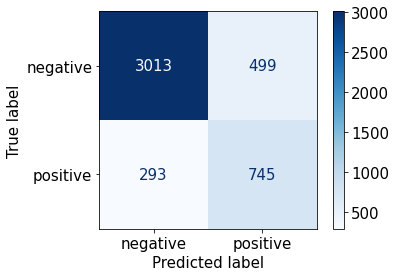

In [460]:
# Confusion matrix of LogisticRegression PipeLine
plot_confusion_matrix(logreg_pipe, X_test, 
                      y_test, 
                      cmap='Blues', 
                      display_labels = ['negative', 'positive']);

In [461]:
print(f'True negatives: {str(tn)}' )
print(f'True positives: {str(tp)}' )
print(f'False negatives: {str(fn)}' )
print(f'False positives: {str(fp)}' )

spec = tn / (tn + fp)

print('Specificity:', spec)

True negatives: 3013
True positives: 745
False negatives: 293
False positives: 499
Specificity: 0.8579157175398633


In [462]:
model_scores.loc['LogisticRegression_Oversample'] = [0.9, 0.83, 0.82, 0.83, 0.82, 0.83]

### 6.2 XGBClassifier & Over Sampling

In [463]:
xgb_pipe = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('sampler', RandomOverSampler('minority',random_state=42)),
                       ('xgb', XGBClassifier(random_state=42))])

In [464]:
cross_val_score(xgb_pipe, X_train, y_train, cv=5, error_score='raise').mean()

0.819294846666131

In [465]:
xgb_pipe.fit(X_train, y_train)
print(xgb_pipe.score(X_train, y_train))
print(xgb_pipe.score(X_test, y_test))

0.9386659129451668
0.814945054945055


In [466]:
eval_pipeline(xgb_pipe)

              precision    recall  f1-score   support

    positive       0.90      0.86      0.88      3512
    negative       0.58      0.67      0.62      1038

    accuracy                           0.81      4550
   macro avg       0.74      0.76      0.75      4550
weighted avg       0.83      0.81      0.82      4550




In [467]:
# Get predictions
preds = xgb_pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

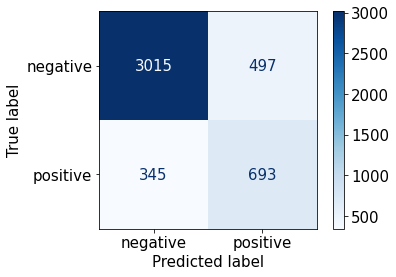

In [468]:
# View confusion matrix
plot_confusion_matrix(xgb_pipe, X_test, 
                      y_test, 
                      cmap='Blues', 
                      display_labels = ['negative', 'positive']);

In [469]:
print(f'True negatives: {str(tn)}' )
print(f'True positives: {str(tp)}' )
print(f'False negatives: {str(fn)}' )
print(f'False positives: {str(fp)}' )

spec = tn / (tn + fp)

print('Specificity:', spec)

True negatives: 3015
True positives: 693
False negatives: 345
False positives: 497
Specificity: 0.8584851936218679


In [470]:
model_scores.loc['XGBClassifier_Oversample'] = [0.94, 0.82, 0.81, 0.83, 0.81, 0.82]

### 6.3 MultinomialNB & Over Sampling

In [471]:
nb_pipe = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('sampler', RandomOverSampler('minority',random_state=42)),
                    ('nb', MultinomialNB())])

In [472]:
cross_val_score(nb_pipe, X_train, y_train, cv=5, error_score='raise').mean()

0.7502354935820286

In [473]:
nb_pipe.fit(X_train, y_train)
print(nb_pipe.score(X_train, y_train))
print(nb_pipe.score(X_test, y_test))

0.8289052195213868
0.754065934065934


In [474]:
eval_pipeline(nb_pipe)

              precision    recall  f1-score   support

    positive       0.93      0.74      0.82      3512
    negative       0.48      0.80      0.60      1038

    accuracy                           0.75      4550
   macro avg       0.70      0.77      0.71      4550
weighted avg       0.82      0.75      0.77      4550




In [475]:
# Get predictions
preds = nb_pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

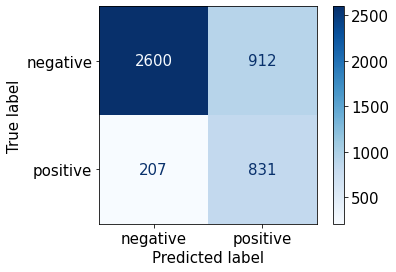

In [476]:
# View confusion matrix
plot_confusion_matrix(nb_pipe, X_test, 
                      y_test, 
                      cmap='Blues', 
                      display_labels = ['negative', 'positive']);

In [477]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

spec = tn / (tn + fp)

print('Specificity:', spec)

True negatives: 2600.
True positives: 831.
False negatives: 207.
False positives: 912.
Specificity: 0.7403189066059226


In [478]:
model_scores.loc['MultinomialNB_Oversample'] = [0.83, 0.75, 0.75, 0.82, 0.75, 0.77]

### 6.4 XGBClassifier & Under Sampling

In [479]:
xgb_pipe_under = Pipeline([('cvect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('sampler', RandomUnderSampler('majority',random_state=42)),
                     ('xgb', XGBClassifier(random_state=42))])

In [480]:
cross_val_score(xgb_pipe_under, X_train, y_train, cv=5, error_score='raise').mean()

0.7862261670683679

In [481]:
xgb_pipe_under.fit(X_train, y_train)
print(xgb_pipe_under.score(X_train, y_train))
print(xgb_pipe_under.score(X_test, y_test))

0.855191256830601
0.7738461538461539


In [482]:
eval_pipeline(xgb_pipe_under)

              precision    recall  f1-score   support

    positive       0.93      0.77      0.84      3512
    negative       0.50      0.79      0.61      1038

    accuracy                           0.77      4550
   macro avg       0.71      0.78      0.73      4550
weighted avg       0.83      0.77      0.79      4550




In [483]:
# Get predictions
preds = nb_pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

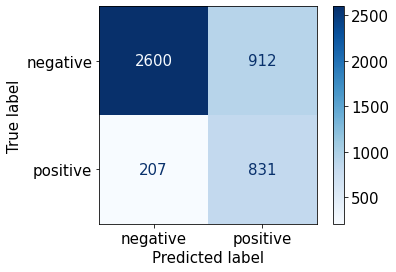

In [484]:
# View confusion matrix
plot_confusion_matrix(nb_pipe, X_test, 
                      y_test, 
                      cmap='Blues', 
                      display_labels = ['negative', 'positive']);

In [485]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

spec = tn / (tn + fp)

print('Specificity:', spec)

True negatives: 2600.
True positives: 831.
False negatives: 207.
False positives: 912.
Specificity: 0.7403189066059226


In [486]:
model_scores.loc['XGBClassifier_Undersample'] = [0.86, 0.77, 0.77, 0.83, 0.77, 0.79]

# 7. Model Scores

In [487]:
model_scores.sort_values(by='Accuracy', ascending=False)

,Train Score,Test Score,Accuracy,Precision,Recall,F1-Score
LogisticRegression_Oversample,0.9,0.83,0.82,0.83,0.82,0.83
XGBClassifier_Oversample,0.94,0.82,0.81,0.83,0.81,0.82
XGBClassifier_Undersample,0.86,0.77,0.77,0.83,0.77,0.79
MultinomialNB_Oversample,0.83,0.75,0.75,0.82,0.75,0.77


# 8. Conclusion

For the NLP portion we decided to run 3 different models; Logistic Regression, XGBClassifier, and MultinomialNB. The reason we chose these models was because these were the best performing models for the categorical data. For each one of these models we ran a sampler, CountVectorizer, and TfidfVectorizer. The reason we decided to to use a sampler was because our data was very unbalanced and even though the unbalanced model performed well, we knew we could not trust the accuracy of the score. As for running both CountVectorizer and TfidfTransformer together, this was because when we tested them, each vectorizer identified seperate set of words.

After some balancing and tuning, the best performing model was the pipeline with Logistic Regression model, undersampling, CountVectorizer & TfidfTransformer. We got a test score of 0.83, train score of 0.90, and an accuracy score of 0.82. XGBClassifier was a close second but overall, Logistic Regression is faster and scored higher than the rest.

#### Recommendations/ Next Steps:

Our recommendation for this dataset would be to use LogisticRegression and to balance the data by over sampling. If we can move beyond this data, we would recommend to find data that is more balanced so the scoring can be alot more clear. Many of the words in the notes column were places and people, and if we had more time to continue looking at this data we could proceed by seeing if there was any correlation between negative state responses and country. By doing this we could see if specific locations have higher negative state responses.